In [1]:
import os
import pickle
# import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
# from torch_geometric.loader import HGTLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from torchsummary import summary
import random
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from torch.utils.data import WeightedRandomSampler
import math
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch.nn.parameter import Parameter


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(2022)


class MLPBilPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
        super(MLPBilPredictor, self).__init__()
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels[0]))
        for i in range(num_layers - 1):
            self.lins.append(torch.nn.Linear(hidden_channels[i], hidden_channels[i + 1]))
        self.bilin = torch.nn.Linear(hidden_channels[-1], hidden_channels[-1], bias=False)
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
        self.relu = nn.GELU()

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        self.bilin.reset_parameters()

    def forward(self, x_i, x_j):
        for lin in self.lins:
            x_i, x_j = lin(x_i), lin(x_j)
            x_i, x_j = self.dropout(self.relu(x_i)), self.dropout(self.relu(x_j))
        x = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
        # x = x1+x2
        # x = torch.sum(x_i * x_j, dim=-1)
        return x, x_i, x_j


# class MLPBilPredictor(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
#         super(MLPBilPredictor, self).__init__()
#         self.lins = torch.nn.ModuleList()
#         self.lins.append(torch.nn.Linear(in_channels, hidden_channels[0]))
#         for i in range(num_layers - 1):
#             self.lins.append(torch.nn.Linear(hidden_channels[i], hidden_channels[i+1]))
#         # self.bilin = torch.nn.Linear(hidden_channels, hidden_channels, bias=False)
#         # self.bilin = torch.nn.Linear(in_channels,in_channels, bias=False)
#         self.pre = torch.nn.Linear(hidden_channels[-1],1)
#         self.relu = nn.GELU()
#         self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
#
#     def reset_parameters(self):
#         for lin in self.lins:
#             lin.reset_parameters()
#         self.lin.reset_parameters()
#
#     def forward(self, x):
#         for lin in self.lins:
#             x= lin(x)
#             x= self.dropout(self.relu(x))
#         x = self.pre(x)
#         # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
#         # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
#         # x = x1+x2
#         # x = torch.sum(x_i * x_j, dim=-1)
#         return x

class HerGraph(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(HerGraph, self).__init__()
        self.pre = MLPBilPredictor(3200 + 128, [1024], 1, 0.3)
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
        self.relu = nn.GELU()

    def decoderMLP(self, xm, xg, edge):
        xm = xm[edge[0]]
        xg = xg[edge[1]]
        s, xm, xg = self.pre(xm, xg)
        return s, xm, xg

    def forward(self, seq_dict, x_dict, edge_index_dict, label_edge):
        xm1 = seq_dict['miRNA']
        xg1 = seq_dict['gene']
        xm2 = x_dict['miRNA']
        xg2 = x_dict['gene']
        xm = self.dropout(self.relu(torch.cat([xm1, xm2], dim=1)))
        xg = self.dropout(self.relu(torch.cat([xg1, xg2], dim=1)))
        s, xm, xg = self.decoderMLP(xm, xg, label_edge)
        return s, xm, xg


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduce='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, classifications, targets):
        # classifcation:[N,K]
        # targets: [N,K]的one-hot编码
        alpha = self.alpha
        gamma = self.gamma
        # classifications = classifications.view(-1)  # 不经过sigmoid的classification；
        # targets = targets.view(-1)                  # 应该是 one-hot
        # ce_loss: 对应公式中 -log(pt),也就是普通的 交叉熵损失；--> 该函数接收未经sigmoid的函数；
        ce_loss = F.binary_cross_entropy_with_logits(classifications, targets, reduction="none")
        # focal loss
        p = torch.sigmoid(classifications)  # 经过sigmoid
        p_t = p * targets + (1 - p) * (1 - targets)  # 计算pt
        loss = ce_loss * ((1 - p_t) ** gamma)  # -log(pt) * (1-pt) ** ganmma
        if alpha >= 0:
            # 对应公式中alpha_t控制损失的权重
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets)  # 和pt求解过程一样
            loss = alpha_t * loss  # 最终focal loss
        if self.reduce == 'sum':
            loss = loss.sum()
        elif self.reduce == 'mean':
            loss = loss.mean()
        else:
            raise ValueError('reduce type is wrong!')
        return loss


class BCEFocalLoss(torch.nn.Module):

    def __init__(self, gamma=2, alpha=0.25, reduction='elementwise_mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, _input, target):
        pt = torch.sigmoid(_input)
        loss = - self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
               (1 - self.alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)
        #         loss = - self.alpha * pt ** self.gamma * target * torch.log(pt) - \
        #             (1-self.alpha)*(1 - pt)** self.gamma * (1 - target) * torch.log(1 - pt)
        if self.reduction == 'elementwise_mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss


def trainAll(model, train_data, lossF):
    model.train()
    out, _, _ = model(train_data.seq_dict, train_data.sim_dict, train_data.edge_index_dict,
                      train_data['regulate'].edge_label_index)
    out = out.view(-1)
    # print('out')
    rel = train_data['regulate'].edge_label
    # loss = F.binary_cross_entropy_with_logits(out,rel)
    loss = lossF(out, rel)
    pre = torch.sigmoid(out)
    assert torch.isnan(loss).sum() == 0, print(loss)
    auc = roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    aupr = average_precision_score(rel.detach().numpy(), pre.detach().numpy())
    #     out = model(train_data.x_dict,train_data.edge_index_dict)
    #     pre=out[train_data['regulate'].edge_label_index[0],train_data['regulate'].edge_label_index[1]]
    #     rel=train_data['regulate'].edge_label
    #     loss = F.binary_cross_entropy_with_logits(pre,rel)
    #     pre=torch.sigmoid(pre)
    #     assert torch.isnan(loss).sum() == 0, print(loss)
    #     auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return (loss.item(), auc, aupr)


def evaluateAll(model, dat, lossF):
    model.eval()
    valloss = 0
    valauc = 0
    with torch.no_grad():
        out, _, _ = model(dat.seq_dict, dat.sim_dict, dat.edge_index_dict, dat['regulate'].edge_label_index)
        out = out.view(-1)
        rel = dat['regulate'].edge_label
        # loss = F.binary_cross_entropy_with_logits(out,rel)
        loss = lossF(out, rel)
        pre = torch.sigmoid(out)
        #         out = model(dat.x_dict,dat.edge_index_dict)
        #         pre=out[dat['regulate'].edge_label_index[0],dat['regulate'].edge_label_index[1]]
        #         rel=dat['regulate'].edge_label
        #         loss = F.binary_cross_entropy_with_logits(pre,rel)
        #         pre=torch.sigmoid(pre)
        auc = roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
        aupr = average_precision_score(rel.detach().numpy(), pre.detach().numpy())
    return (loss.item(), auc, aupr)


class EarlyStopping():
    def __init__(self, tolerance=50, min_delta=0.1):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_best_auc, val_auc):
        if val_auc < val_best_auc:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True


def transfer_model(pretrained_file, model):
    pretrained_dict = torch.load(pretrained_file, map_location=torch.device('cpu'))  # get pretrained dict
    model_dict = model.state_dict()  # get model dict
    pretrained_dict = transfer_state_dict(pretrained_dict, model_dict)
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model


def transfer_state_dict(pretrained_dict, model_dict):
    state_dict = {}
    for k, v in pretrained_dict.items():
        if k in model_dict.keys():
            state_dict[k] = v
        else:
            print("Missing key(s) in state_dict :{}".format(k))
    return state_dict


if __name__ == '__main__':
    with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newdataCombine00_newall.pkl',
              'rb') as f:  # Python 3: open(..., 'rb')
        train_data, val_data, test_data, m, g = pickle.load(f)

    # train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
    # val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
    # test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
    # train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
    # val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
    # test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
    # nodetypes=train_data.node_types
    # metadata=train_data.metadata()

    with open('/lustre06/project/6050659/liupei89/Testcell/TranCNN13_mgEmbedding_1.pkl',
              'rb') as f:  # Python 3: open(..., 'rb')
        xm1, xg1 = pickle.load(f)

    train_data['miRNA'].seq = xm1
    val_data['miRNA'].seq = xm1
    test_data['miRNA'].seq = xm1
    train_data['gene'].seq = xg1
    val_data['gene'].seq = xg1
    test_data['gene'].seq = xg1

    with open('/lustre06/project/6050659/liupei89/Testcell/HGT6_mgEmbedding_1.pkl',
              'rb') as f:  # Python 3: open(..., 'rb')
        xm2, xg2 = pickle.load(f)

    train_data['miRNA'].sim = xm2
    val_data['miRNA'].sim = xm2
    test_data['miRNA'].sim = xm2
    train_data['gene'].sim = xg2
    val_data['gene'].sim = xg2
    test_data['gene'].sim = xg2

#     model = HerGraph(dropout_rate=0.3)

#     print(model)

#     for m in model.modules():
#         if isinstance(m, (torch.nn.Linear, torch.nn.Conv1d, torch.nn.Conv2d)):
#             torch.nn.init.kaiming_normal_(m.weight, mode='fan_in')

#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-3)
#     lossF = FocalLoss(alpha=0.65, gamma=2, reduce='mean')
#     # lossF=BCEFocalLoss(gamma=1, alpha=0.75, reduction='elementwise_mean')
#     early_stopping = EarlyStopping(tolerance=200, min_delta=0.15)

#     import time

#     best_val_auc = best_val_aupr = 0
#     trainloss = []
#     valloss = []
#     valauc = []
#     trainauc = []
#     valaupr = []
#     trainaupr = []
#     lrchange = []
#     for epoch in range(1, 2001):
#         since = time.time()
#         print('{} optim: {}'.format(epoch, optimizer.param_groups[0]['lr']))
#         lrchange.append(optimizer.param_groups[0]['lr'])
#         train_loss, train_auc, train_aupr = trainAll(model, train_data, lossF)
#         trainloss.append(train_loss)
#         print('train_loss:', train_loss)
#         # time_elapsed = time.time() - since
#         # print('Training in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         # since1 = time.time()
#         val_loss, val_auc, val_aupr = evaluateAll(model, val_data, lossF)
#         valauc.append(val_auc)
#         valloss.append(val_loss)
#         trainauc.append(train_auc)
#         valaupr.append(val_aupr)
#         trainaupr.append(train_aupr)
#         # time_elapsed = time.time() - since1
#         # print('Val and Testing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         if val_aupr > best_val_aupr:
#             best_val_auc = val_auc
#             best_val_aupr = val_aupr
#             torch.save(model, 'HerMLPbest.pt')
#         #    test_auc= tmp_test_auc
#         # scheduler.step()
#         time_elapsed = time.time() - since
#         log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#         print(log.format(epoch, time_elapsed // 60, time_elapsed % 60, train_loss, val_loss, train_auc, val_auc,
#                          best_val_auc, train_aupr, val_aupr, best_val_aupr))

#         # early_stopping(train_auc, val_auc)
#         # if early_stopping.early_stop:
#         #     print("We are at epoch:", epoch)
#         #     break

#     with open('HerMLPResult.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#         pickle.dump([trainloss, trainauc, trainaupr, valloss, valauc, valaupr, lrchange], f)

#     torch.save(model, 'HerMLP.pt')

In [2]:
import matplotlib.pyplot as plt

In [4]:
### data 00
#/home/liupei89/shfolder/new/HGT/5/0.001_2_0.35_5e-3_1000
#HGT = torch.load("/home/liupei89/shfolder/new/HGT/6/128/HGTbest.pt")
#Her = torch.load("/home/liupei89/shfolder/Herbest.pt")
Her = torch.load("/home/liupei89/shfolder/new/Her/HerMLP/2000_0.0001/HerMLPbest.pt")

In [5]:
Her

HerGraph(
  (pre): MLPBilPredictor(
    (lins): ModuleList(
      (0): Linear(in_features=3328, out_features=1024, bias=True)
    )
    (bilin): Linear(in_features=1024, out_features=1024, bias=False)
    (dropout): Dropout(p=0.3, inplace=False)
    (relu): GELU()
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): GELU()
)

In [6]:
test_data

HeteroData(
  miRNA={
    x=[279, 279],
    seq=[279, 3200],
    mm=[279, 279],
    sim=[279, 128]
  },
  gene={
    x=[14676, 14676],
    seq=[14676, 3200],
    gg=[14676, 14676],
    sim=[14676, 128]
  },
  (miRNA, regulate, gene)={
    edge_index=[2, 73905],
    edge_label_index=[2, 8213],
    edge_label=[8213]
  },
  (gene, coocurrence, gene)={ edge_index=[2, 2087674] },
  (miRNA, cofamily, miRNA)={ edge_index=[2, 418] },
  (gene, rev_regulate, miRNA)={ edge_index=[2, 73905] }
)

In [7]:
Her.eval()
valloss = 0
valauc = 0
with torch.no_grad():
    out, _, _ = Her(test_data.seq_dict, test_data.sim_dict, test_data.edge_index_dict, test_data['regulate'].edge_label_index)
    out = out.view(-1)
    rel = test_data['regulate'].edge_label
    # loss = F.binary_cross_entropy_with_logits(out,rel)
    #loss = lossF(out, rel)
    pre = torch.sigmoid(out)
    auc = roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    aupr = average_precision_score(rel.detach().numpy(), pre.detach().numpy())

In [8]:
print(auc,aupr)

0.8705548759102928 0.8108665734192012


In [9]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [10]:
rel[rel==1].size()

torch.Size([2223])

In [11]:
#rel[rel==1].size()
allrelpos=torch.nonzero(rel==1).squeeze()
print(allrelpos.size())
allrelneg=torch.nonzero(rel==0).squeeze()
print(allrelneg.size())

allprepos=torch.nonzero(pre>=0.5).squeeze()##从0开始
print(allprepos.size())
allpreneg=torch.nonzero(pre<0.5).squeeze()##从0开始
print(allpreneg.size())

torch.Size([2223])
torch.Size([5990])
torch.Size([1900])
torch.Size([6313])


In [12]:
a=set(allprepos.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
tp=c
print(tp.size())#1545

a=set(allprepos.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
fp=c
print(fp.size())#779

a=set(allpreneg.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
tn=c
print(tn.size())#5211

a=set(allpreneg.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
fn=c
print(fn.size())#678

torch.Size([1508])
torch.Size([392])
torch.Size([5598])
torch.Size([715])


In [13]:
tp.size(0)+fn.size(0)

2223

In [14]:
recall=tp.size(0)/(tp.size(0)+fn.size(0))
print(recall)

0.6783625730994152


In [15]:
precision=tp.size(0)/(tp.size(0)+fp.size(0))
print(precision)

0.7936842105263158


In [16]:
f1 = 2 * precision * recall / (precision + recall)
print(f1)

0.7315061848168809


In [17]:
with open('HerMLP_result.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([tp,fp,tn,fn,rel,pre], f)

In [18]:
pre

tensor([0.2986, 0.7279, 0.0917,  ..., 0.0091, 0.0216, 0.5639])

In [19]:
rel

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [43]:
# HGT.eval()
# valloss=0
# valauc=0
# with torch.no_grad():
#     out = HGT(train_data.sim_dict,train_data.edge_index_dict,train_data['regulate'].edge_label_index)
#     out=out.view(-1)
#     rel=train_data['regulate'].edge_label
#     #loss = F.binary_cross_entropy_with_logits(out,rel)
#     pre=torch.sigmoid(out) 

#     auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())

In [7]:
# max(pre)

tensor(1.)

In [21]:
with open('HerMLP_result.pkl','rb') as f:  # Python 3: open(..., 'rb')
        _,_,_,_,rel,pre = pickle.load(f)

In [22]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [23]:
fpr, tpr, thresholds = roc_curve(rel.numpy(), pre.numpy(), pos_label=1)
testauc=auc(fpr,tpr)
testauc

0.8705548759102928

In [24]:
precision, recall, _ = precision_recall_curve(rel.numpy(), pre.numpy(),pos_label=1)
testaupr= average_precision_score(rel.numpy(), pre.numpy())
testaupr #0.8026

0.8108665734192012

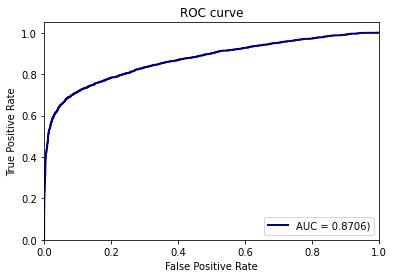

In [25]:
plt.figure()
plt.step(fpr, tpr,color='navy',linewidth=2,label='AUC = {0:.4f})'.format(testauc))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
#plt.savefig("auc_curve.jpg")

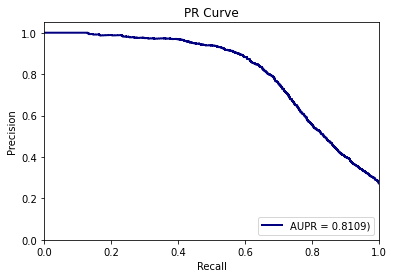

In [26]:
plt.figure()
plt.step(recall,precision,color='navy',linewidth=2,label='AUPR = {0:.4f})'.format(testaupr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR Curve')
plt.legend(loc=4)
#plt.savefig("pr_curve.jpg")

In [25]:
#data 00
#/home/liupei89/shfolder/new/HGT/5/0.001_2_0.35_5e-3_1000
#/home/liupei89/shfolder/new/HGT/5
with open('/home/liupei89/shfolder/new/Her/HerMLP/2000_0.0001/HerMLPResult.pkl','rb') as f:  # Python 3: open(..., 'rb')
       trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange = pickle.load(f)

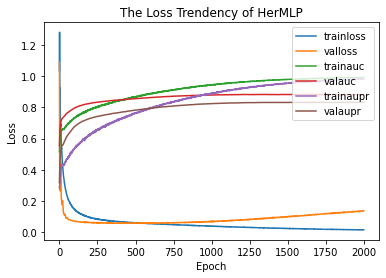

In [29]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss')
plt.plot(valloss,label='valloss')
plt.plot(trainauc,label='trainauc')
plt.plot(valauc,label='valauc')
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of HerMLP')
plt.legend(loc=1)

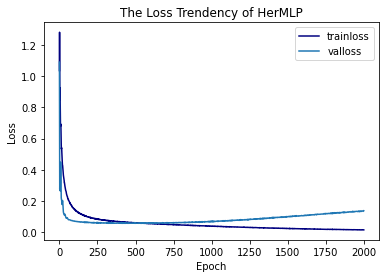

In [30]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss',color='navy')
plt.plot(valloss,label='valloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of HerMLP')
plt.legend(loc=1)

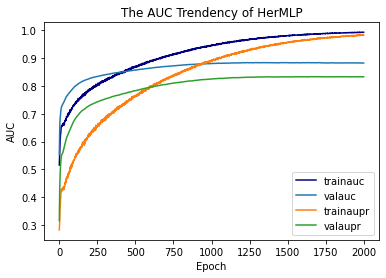

In [31]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('The AUC Trendency of HerMLP')
plt.legend(loc=4)

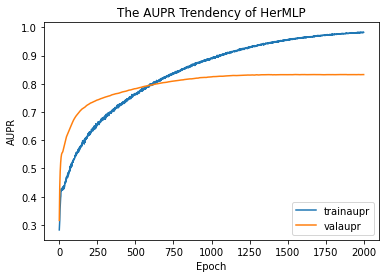

In [32]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUPR')
#plt.ylim([0.5, 0.71])
plt.title('The AUPR Trendency of HerMLP')
plt.legend(loc=4)

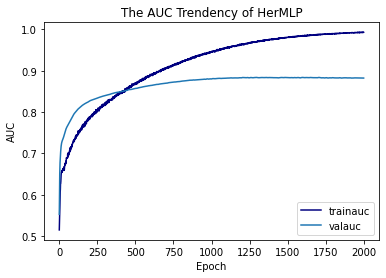

In [33]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('The AUC Trendency of HerMLP')
plt.legend(loc=4)

In [27]:
for name,parameters in Her.named_parameters():
    print(name,':',parameters.size())

pre.lins.0.weight : torch.Size([1024, 3328])
pre.lins.0.bias : torch.Size([1024])
pre.bilin.weight : torch.Size([1024, 1024])


In [28]:
#torch.save(HGT.state_dict(),'HGT6_00newall_1BiLinear_new.pth')
# torch.save(HGT.state_dict(),'HGT_00newall_BiLinear.pth')
torch.save(Her.state_dict(),'HerMLP.pth')

In [36]:
# input1 = torch.randn(5, 128)
# input2 = torch.randn(10, 128)
# label=torch.tensor([1,1,1,1,1,0,0,0,0,0])
# label=1-label
# loss=0
# for i in range(0,input1.size(0)):
#     euclidean_distance = F.pairwise_distance(input1[i,:], input2, p=2) 
#     print(euclidean_distance.size())
#     loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
#                               (label) * torch.pow(torch.clamp(2 - euclidean_distance, min=0.0), 2))
#     loss=loss+loss_contrastive
#     print(loss_contrastive)
   

    
# loss=loss/(i+10)  
# print(loss)